In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from lag_llama.gluon.estimator import LagLlamaEstimator

from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.model.forecast import SampleForecast, QuantileForecast
from sklearn.metrics import mean_absolute_percentage_error
import copy
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.torch.model.deepar.module import DeepARModel


/Users/rodolphefarrando/Documents/tilt_ds/gluonts/src/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
df = pd.read_parquet("../data/tte_data.parquet")
or_df = df.copy()
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 366)
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 366)
weather_features = [
    "precip_",
    "temp",
    "solarradiation",
    "solarproduction",
    "humidity",
    "precipcover",
]
for w in weather_features:
    df[f"D1_{w}_Q50"] = df[
        [c for c in df.columns if "D1" in c and w in c]
    ].mean(axis=1)
    df[f"D1_{w}_Q10"] = df[
        [c for c in df.columns if "D1" in c and w in c]
    ].quantile(0.1, axis=1)
    df[f"D1_{w}_Q90"] = df[
        [c for c in df.columns if "D1" in c and w in c]
    ].quantile(0.9, axis=1)
    df[f"actual_{w}_Q50"] = df[
        [c for c in df.columns if "actual" in c and w in c]
    ].mean(axis=1)
    df[f"actual_{w}_Q10"] = df[
        [c for c in df.columns if "actual" in c and w in c]
    ].quantile(0.1, axis=1)
    df[f"actual_{w}_Q90"] = df[
        [c for c in df.columns if "actual" in c and w in c]
    ].quantile(0.9, axis=1)

future_features = (
    [
        # "hour",
        # "dayofweek",
        # "month",
        # "dayofyear_cos",
        # "dayofyear_sin",
        "ferie",
        "vacances_wallonie",
        "vacances_flandre",
    ]
    + [c for c in df.columns if "Q" in c and "D" in c]
    # + [c for c in df.columns if "W1" in c and "solar" in c]
    # + [c for c in df.columns if "eliaload_weekaheadforecast" in c]
    # + [c for c in df.columns if "monitoredcapacity_solar_Belgium" in c]
)
past_features = [c for c in df.columns if "Q" in c and "actual" in c]


print(f"Number of features {len(future_features + past_features)}")

df["scaled_allocs"] = df["prov_allocs"] / df["scale_EAV_total"]
data = df[["scaled_allocs", "scale_EAV_total"] + future_features + past_features]
data.index = data.index.tz_convert("UTC")
df = data.fillna(0)

## Add scaling for the features
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# features_scaler = StandardScaler()
# df[features_to_scale] = features_scaler.fit_transform(df[features_to_scale])

Number of features 39


In [3]:
past_features

['actual_precip__Q50',
 'actual_precip__Q10',
 'actual_precip__Q90',
 'actual_temp_Q50',
 'actual_temp_Q10',
 'actual_temp_Q90',
 'actual_solarradiation_Q50',
 'actual_solarradiation_Q10',
 'actual_solarradiation_Q90',
 'actual_solarproduction_Q50',
 'actual_solarproduction_Q10',
 'actual_solarproduction_Q90',
 'actual_humidity_Q50',
 'actual_humidity_Q10',
 'actual_humidity_Q90',
 'actual_precipcover_Q50',
 'actual_precipcover_Q10',
 'actual_precipcover_Q90']

In [4]:
train_df = df.loc["2022-03":"2023-02"].reset_index()
train_df["timepoint"] = train_df["timepoint"].dt.tz_localize(None)

full_df = df.loc["2022-03":"2023-03"].reset_index()
full_df["timepoint"] = full_df["timepoint"].dt.tz_localize(None)

val_df = df.loc["2023-02":"2023-03"].reset_index()
val_df["timepoint"] = val_df["timepoint"].dt.tz_localize(None)

In [5]:
# Convert DataFrame to GluonTS PandasDataset format
train_dataset = PandasDataset(
    dataframes=train_df,
    target="scaled_allocs",
    timestamp="timepoint",
    freq="1h",
    feat_dynamic_real=future_features,
    past_feat_dynamic_real=past_features,
)

full_dataset = PandasDataset(
    dataframes=full_df,
    target="scaled_allocs",
    timestamp="timepoint",
    freq="1h",
    feat_dynamic_real=future_features,
    past_feat_dynamic_real=past_features,
)

val_dataset = PandasDataset(
    dataframes=val_df,
    target="scaled_allocs",
    timestamp="timepoint",
    freq="1h",
    feat_dynamic_real=future_features,
    past_feat_dynamic_real=past_features,
)

In [7]:
pred_day_number = 14
prediction_length = pred_day_number * 24
num_samples = 200
context_length = 14 * 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=context_length,
    freq="h",
    num_feat_dynamic_real=len(future_features),
    num_feat_static_cat=0,
    num_feat_static_real=0,
    lr=1e-3,
    weight_decay=1e-8,
    scaling=True,
    hidden_size=32,
    num_layers=4,
    dropout_rate=0.4,
    # embedding_dimension=20,
    batch_size=8,
    num_batches_per_epoch=50,
    trainer_kwargs=dict(
        max_epochs=2,
        accelerator="auto",
        enable_checkpointing=True,
        enable_progress_bar=True,
        enable_model_summary=False,
        # callbacks=[CustomProgressBar()],
    ),
)

# Train the model
predictor = estimator.train(training_data=train_dataset, validation_data=val_dataset)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 0: |          | 0/? [00:00<?, ?it/s]                                 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [44]:
start = "2023-02-01"
date_range = pd.date_range(start=f"{start} 23:00", end="2023-10-31 23:00", freq="D", tz="UTC")

forecasts = np.empty((num_samples, 0))
period = None
for i, date in enumerate(date_range):
    if i % 15 == 0:
        print(f"Prediction ending on {date}")
    df_ = df.loc[:date].reset_index()
    df_["timepoint"] = df_["timepoint"].dt.tz_localize(None)
    # scale = data.loc[date - pd.Timedelta(23, "h") : date, "scale_EAV_total"].values
    # df_[features] = features_scaler.transform(df_[features])
    test_dataset = PandasDataset(
        dataframes=df_,
        target="scaled_allocs",
        timestamp="timepoint",
        freq="1h",
        feat_dynamic_real=features,
        # unchecked=True # apprently i have missing values in the df in june this allows to go pass that
    )
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=num_samples,  # number of sample paths we want for evaluation
    )   
    forecast = list(forecast_it)[0] 
    forecasts = np.hstack((forecasts, forecast.samples[:, -24:]))
    p_ = forecast.start_date + pd.Timedelta(prediction_length - 24, "h")
    if period is None:
        period = p_
        print(p_, date)

Prediction ending on 2023-02-01 23:00:00+00:00
2023-02-01 00:00 2023-02-01 23:00:00+00:00
Prediction ending on 2023-02-16 23:00:00+00:00
Prediction ending on 2023-03-03 23:00:00+00:00
Prediction ending on 2023-03-18 23:00:00+00:00
Prediction ending on 2023-04-02 23:00:00+00:00
Prediction ending on 2023-04-17 23:00:00+00:00
Prediction ending on 2023-05-02 23:00:00+00:00
Prediction ending on 2023-05-17 23:00:00+00:00
Prediction ending on 2023-06-01 23:00:00+00:00
Prediction ending on 2023-06-16 23:00:00+00:00
Prediction ending on 2023-07-01 23:00:00+00:00
Prediction ending on 2023-07-16 23:00:00+00:00
Prediction ending on 2023-07-31 23:00:00+00:00
Prediction ending on 2023-08-15 23:00:00+00:00
Prediction ending on 2023-08-30 23:00:00+00:00
Prediction ending on 2023-09-14 23:00:00+00:00
Prediction ending on 2023-09-29 23:00:00+00:00
Prediction ending on 2023-10-14 23:00:00+00:00
Prediction ending on 2023-10-29 23:00:00+00:00


In [45]:
gluon_forecasts = SampleForecast(
    samples=forecasts, start_date=pd.Period(f"{start} 00:00", "H")
)

In [46]:
results_df = gluon_forecasts.mean_ts.to_timestamp().to_frame(name="Tilt")
results_df.index = results_df.index.tz_localize("UTC")
results_df = results_df.merge(
    df[["scale_EAV_total", "scaled_allocs"]],
    left_index=True,
    right_index=True,
    how="left",
)
#results_df["Tilt rescaled"] = results_df["Tilt"] * results_df["scale"]
results_df.index.name = "timepoint"

In [50]:
mean_absolute_percentage_error(
    results_df.loc["2023-05", "scaled_allocs"], results_df.loc["2023-05", "Tilt"]
)

0.0872060350936879

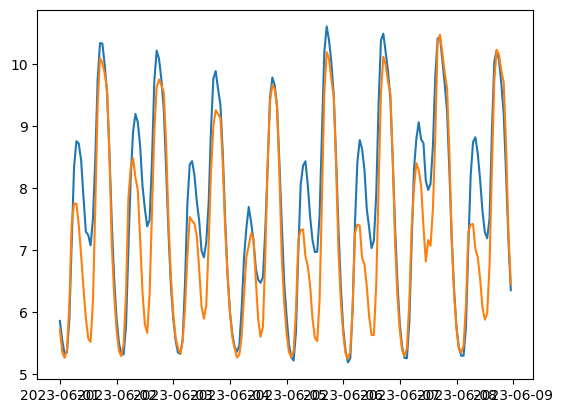

In [48]:
plt.plot(results_df["Tilt"]['2023-06-01':'2023-06-08'])
plt.plot(results_df["scaled_allocs"]["2023-06-01":"2023-06-08"])

In [49]:
import altair as alt
alt.data_transformers.enable("vegafusion")

col = ["Tilt", "scaled_allocs"]

color_dict = {
    "y": "blue",
    "Tilt": "green",
    "scaled_allocs": "orange",
    "GE": "black",
}

df_ = results_df.copy()
df_ = df_.reset_index().melt(id_vars=["timepoint"], value_vars=col)

base = (
    alt.Chart(df_)
    .mark_line()
    .encode(
        x=alt.X("timepoint:T"),
        y=alt.Y("value:Q", title="Consumption"),
        color=alt.Color(
            "variable:N", scale=alt.Scale(range=[color_dict[var] for var in col])
        ),
    )
    .properties(width=1200, height=300)
)

brush = alt.selection_interval(encodings=["x"])
upper = base.encode(alt.X("timepoint:T").scale(domain=brush))

lower = base.properties(width=1200, height=60).add_params(brush)

chart = alt.vconcat(upper, lower)
alt.vconcat(upper, lower)

alt.VConcatChart(...)

# Data prep

In [20]:
from gluonts.transform import InstanceSplitter
from gluonts.transform.split import TFTInstanceSplitter
from gluonts.dataset.field_names import FieldName
from gluonts.transform.sampler import ExpectedNumInstanceSampler, UniformSplitSampler

transform = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=UniformSplitSampler(
        p=1.0
    ),
    past_length=context_length, 
    future_length=prediction_length,
    time_series_fields=[FieldName.FEAT_DYNAMIC_REAL], 
)

transformed_ds = list(transform(train_dataset, is_train=True))    

In [21]:
transform = TFTInstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=UniformSplitSampler(p=1.0),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.FEAT_DYNAMIC_REAL],
)

transformed_ds = list(transform(train_dataset, is_train=True))

KeyError: 'observed_values'